### Package and Data Imports

In [1]:
import scanpy as sc
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import scipy as sp
import torch
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [2]:
adata_nonsmkr = sc.read_text('data/internal_nonsmokerslung.expression.txt', delimiter='\t').T
adata_smkr = sc.read_text('data/internal_smokerslung.expression.txt', delimiter='\t').T

In [3]:
adata_nonsmkr.var_names

Index(['ACE2', 'TMPRSS2', 'IL6R', 'IL6ST', 'PCSK1', 'IL6', 'PCSK2', 'CTSE',
       'MYRF', 'MAG', 'MOG', 'MBP', 'PLP1', 'FURIN', 'PCSK4', 'PCSK5', 'PCSK6',
       'PCSK7', 'C1R', 'C2', 'C3', 'C5', 'CFI', 'CTSS', 'CTSL', 'CTSB',
       'CTSC'],
      dtype='object')

### Calculate Correlation Matrix

In [51]:
X = adata_nonsmkr.X
# corr_matrix_nonsmkr = np.corrcoef(X, rowvar=False) #pearson correlation
corr_matrix_nonsmkr, spearman_p_vals = spearmanr(X) #spearman correlation
X = adata_smkr.X
# corr_matrix_smkr = np.corrcoef(X, rowvar=False) #pearson correlation
corr_matrix_smkr, spearman_p_vals = spearmanr(X) #spearman correlation

corr_matrix_smkr

array([[ 1.00000000e+00,  5.00454777e-02,  2.51811820e-02,
         3.39153322e-02, -2.71424908e-03,  5.05733189e-03,
         7.48698807e-03,  1.48248897e-03,  3.98810389e-02,
         1.62095072e-04, -2.32415189e-03,  6.41279656e-02,
        -4.95403321e-04,  3.01592816e-02,  1.12629693e-02,
         2.75662037e-02,  1.38196936e-02,  4.07984476e-02,
         9.90450984e-04,  1.85797192e-02,  6.22884204e-02,
         2.03225454e-02,  3.29944145e-02,  6.48223825e-02,
         1.36667456e-02,  7.75633175e-02,  7.96191432e-02],
       [ 5.00454777e-02,  1.00000000e+00,  1.53637648e-01,
         1.77563590e-01, -8.86693904e-03, -2.75376381e-03,
         1.65671952e-01,  1.84972348e-01,  5.00921367e-02,
         1.57389134e-02,  9.35706394e-05,  9.94253720e-02,
        -2.31200809e-03,  1.24174824e-01,  4.58476474e-02,
         3.16434427e-02,  4.02124944e-02, -9.30026926e-03,
         7.25354227e-02,  3.81377426e-01,  3.48145052e-01,
         1.38132968e-01,  2.00752661e-01,  1.51742002e-

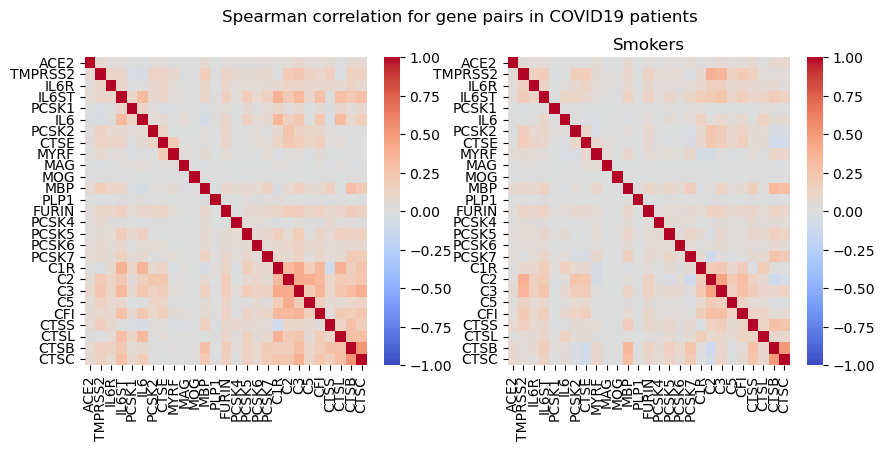

In [56]:
fig, axises = plt.subplots(ncols=2, figsize=(10, 4))
sns.heatmap(corr_matrix_nonsmkr, cmap='coolwarm', vmin=-1, vmax=1, ax=axises[0],
            xticklabels=adata_nonsmkr.var_names, yticklabels=adata_nonsmkr.var_names)
plt.title("Non-smokers")
sns.heatmap(corr_matrix_smkr, cmap='coolwarm', vmin=-1, vmax=1, ax=axises[1],
            xticklabels=adata_smkr.var_names, yticklabels=adata_smkr.var_names)
plt.title("Smokers")
plt.suptitle("Spearman correlation for gene pairs in COVID19 patients", fontsize=12, y=1.0)
plt.show()

### Calculate Mutual Information Matrix

In [22]:
X = adata_nonsmkr.X
num_feat = X.shape[1]
toStack = [[0 for i in range(num_feat)] for j in range(num_feat)]
for col in range(num_feat):
    toStack[col] = mutual_info_classif(X, X[:,col], n_neighbors=3)

27

In [24]:
mi_matrix = np.stack(toStack, axis=1)

<Axes: >

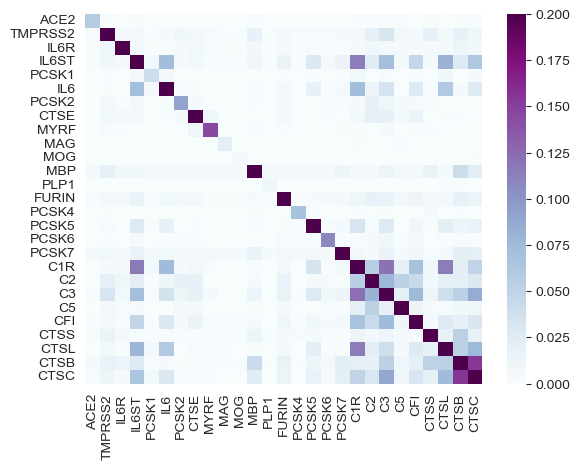

In [26]:
sns.heatmap(mi_matrix, cmap='BuPu', vmax=0.2,
            xticklabels=adata_smkr.var_names, yticklabels=adata_smkr.var_names)

### Random Forest Classifiers

###### create features X and target y

In [4]:
# pd.DataFrame(adata_smkr.X)
# sp.sparse.csr_matrix(adata_smkr.X)
X = np.concatenate([adata_nonsmkr.X, adata_smkr.X]) #combine ndarrays

In [5]:
print(f'# of non-smoker examples is {adata_nonsmkr.X.shape[0]} \n',
      f'# of smoker examples is {adata_smkr.X.shape[0]} \n',
      f'ratio is {adata_smkr.X.shape[0] / adata_nonsmkr.X.shape[0]}')

# of non-smoker examples is 277224 
 # of smoker examples is 96786 
 ratio is 0.3491256168297117


In [6]:
def make_target_from_two_datasets(matrix1: np.ndarray, matrix2: np.ndarray):
    y_1 = [False]*(adata_smkr.X.shape[0])
    y_2 = [True]*(adata_nonsmkr.X.shape[0])
    return np.concatenate([y_1, y_2])
y = make_target_from_two_datasets(adata_nonsmkr.X, adata_smkr)

In [7]:
# shuffle data and split (keeping target class proportions the same)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, shuffle=True, stratify=y)
# over-sample from the least frequent target class to balance the classes
randomOverSampler = RandomOverSampler()
X_train, y_train = randomOverSampler.fit_resample(X_train, y_train)
print(f'# of non-smoker training examples is {y_train[y_train==False].shape[0]} \n',
      f'# of smoker training examples is {y_train[y_train==True].shape[0]}')

# of non-smoker training examples is 110890 
 # of smoker training examples is 110890


In [8]:
rf_model =  RandomForestClassifier(max_depth=20, n_estimators=10)
rf_model.fit(X_train, y_train)
rf_model.score(X_train, y_train)

0.7206961854089639

In [9]:
# Hyperparameter Optimization
rf_grid_search = GridSearchCV(rf_model, n_jobs=-1, return_train_score=True, param_grid={
    'max_depth':    [1, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44],
    'n_estimators': [10]})
rf_grid_search.fit(X_train, y_train)
print(rf_grid_search.score(X_train, y_train))

0.8202001983948056


In [10]:
results = rf_grid_search.cv_results_
pd.DataFrame(results)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,3.623304,2.209562,0.137652,0.050710,4,10,"{'max_depth': 4, 'n_estimators': 10}",0.585445,0.595162,0.601677,...,0.593944,0.005188,11,0.589960,0.594221,0.600280,0.592862,0.592716,0.594008,0.003428
1,8.654165,2.414396,0.271698,0.067778,8,10,"{'max_depth': 8, 'n_estimators': 10}",0.606818,0.613513,0.612837,...,0.610592,0.002410,10,0.614511,0.617470,0.615092,0.617098,0.611755,0.615185,0.002055
2,12.842668,2.730753,0.249415,0.116165,12,10,"{'max_depth': 12, 'n_estimators': 10}",0.624718,0.628145,0.638020,...,0.634268,0.006566,9,0.640088,0.640347,0.648255,0.650047,0.648469,0.645441,0.004311
3,16.057829,5.531819,0.271126,0.059894,16,10,"{'max_depth': 16, 'n_estimators': 10}",0.658490,0.655965,0.662368,...,0.660592,0.003117,8,0.688447,0.682636,0.682968,0.681875,0.683634,0.683912,0.002337
4,14.229852,4.964328,0.406910,0.200022,20,10,"{'max_depth': 20, 'n_estimators': 10}",0.676707,0.679344,0.685837,...,0.684119,0.005467,7,0.719756,0.721086,0.720303,0.721295,0.724524,0.721393,0.001660
5,14.996372,2.735578,0.309614,0.042244,24,10,"{'max_depth': 24, 'n_estimators': 10}",0.695103,0.700086,0.714807,...,0.707512,0.008350,6,0.756820,0.763831,0.762050,0.760534,0.759660,0.760579,0.002355
6,15.095792,1.474124,0.314554,0.060353,28,10,"{'max_depth': 28, 'n_estimators': 10}",0.714041,0.713139,0.728853,...,0.722545,0.007322,5,0.789831,0.790936,0.787013,0.785908,0.784809,0.787700,0.002326
7,14.925973,1.082961,0.392468,0.120368,32,10,"{'max_depth': 32, 'n_estimators': 10}",0.724073,0.722563,0.744138,...,0.734868,0.009482,4,0.805979,0.810437,0.808910,0.807191,0.805973,0.807698,0.001741
8,12.535204,0.738589,0.399573,0.076818,36,10,"{'max_depth': 36, 'n_estimators': 10}",0.728267,0.726689,0.748039,...,0.739228,0.009627,2,0.818711,0.817719,0.814969,0.817404,0.814862,0.816733,0.001546
9,12.985781,0.466219,0.308051,0.075829,40,10,"{'max_depth': 40, 'n_estimators': 10}",0.729371,0.726148,0.747678,...,0.739079,0.009318,3,0.820464,0.821366,0.818993,0.819371,0.818835,0.819806,0.000965


In [38]:
def plot_cross_validation(param_list: list[int], mean_train_score: list[float], mean_validation_score: list[float]):
    fig, ax = plt.subplots()
    ax.plot(param_list, mean_train_score, "lightblue")
    ax.plot(param_list, mean_train_score, 'bo', label="training_score")
    ax.plot(param_list, mean_validation_score, "pink")
    ax.plot(param_list, mean_validation_score, 'ro', label="validation_score")
    ax.set_title('Random Forest Cross Validation Grid Search Results')
    ax.set_xlabel('Max Tree Depth')
    ax.set_ylabel('Mean Validation Score')
    ax.set_xticks(param_list)
    ax.legend()
    # plt.xlim(param_list[0], param_list[-1])
    plt.show()

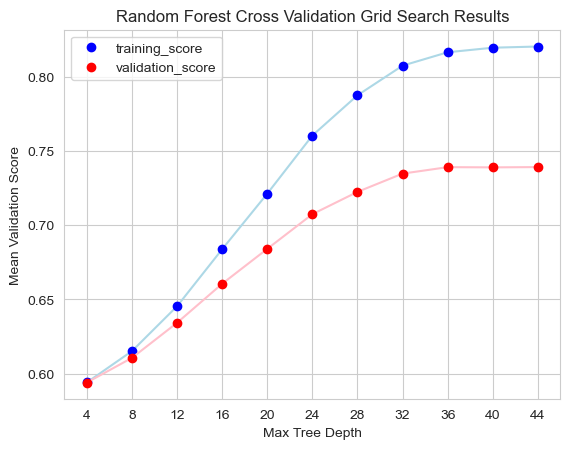

In [39]:
plot_cross_validation(results['param_max_depth'].tolist(), results['mean_train_score'].tolist(), results['mean_test_score'].tolist())

In [40]:
lgbmModel = LGBMClassifier()
catBoostModel = CatBoostClassifier(verbose=0)
xgbModel = XGBClassifier(eval_metric="logloss", verbosity=0)

tree_classifiers = {
    "random forest": rf_model,
    "LightGBM": lgbmModel,
    "CatBoost": catBoostModel,
    #"XGBoost": xgbModel,
}

In [41]:
# Hyperparameter Optimization
lgbm_grid_search = GridSearchCV(lgbmModel, n_jobs=-1, return_train_score=True, param_grid={
    'learning_rate': [0.1],
    'n_estimators': [100]
})
catboost_grid_search = GridSearchCV(catBoostModel, n_jobs=-1, return_train_score=True, param_grid={
    'learning_rate':    [1],
    'n_estimators': [1000]
})

In [29]:
lgbm_grid_search.fit(X_train, y_train)
print(lgbm_grid_search.score(X_train, y_train))

0.6439264135629903


In [53]:
y_train_string = np.array([str(target) for target in y_train])
catboost_grid_search.fit(X_train, y_train)
print(catboost_grid_search.score(X_train, y_train_string))

C:\Users\backp\.conda\envs\445proj1\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\backp\.conda\envs\445proj1\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the train scores are non-finite: [nan]
  warnings.warn(


0.7303724411579042
